# Carcass interpolation model

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected. 

A possible approach to the task of semi-automatic horizon detection is to track reflection by hand on a very sparse grid and use a neural network to interpolate it on the whole seismic (spatial) range. This notebook shows how to do it in details.

* [Dataset](Dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Inference](inference)

In [1]:
# Necessary imports
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../../seismiqb')
from seismiqb.batchflow import Pipeline, set_gpus
from seismiqb.batchflow import B, C, V, P, R
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock

from seismiqb import SeismicDataset, Horizon
from seismiqb import SeismicSampler, Accumulator3D, RegularGrid, plot_loss

# Set GPU
set_gpus(n=1, min_free_memory=0.3)

`CUDA_VISIBLE_DEVICES` set to "2"


In [2]:
# Global parameters
CROP_SHAPE = (1, 192, 192)       # shape of sampled 3D crops
ITERS = 50                       # number of train iterations
BATCH_SIZE = 128                 # number of crops inside one batch

<a id='dataset'></a>
# Dataset

We use only one cube and one horizon carcass (horizon on a sparce grid) at a time. The next cell loads them into one entity `train_dataset`:

In [3]:
cube_path = 'demo_cube.sgy'
carcass_path = 'carcass_0.char'

train_dataset = SeismicDataset({cube_path : carcass_path}, labels_class='horizon')

field = train_dataset[0]
carcass = field.labels[0]

It is always nice to look at your data: the next cells show horizon depth map, as well as an example of seismic slice.

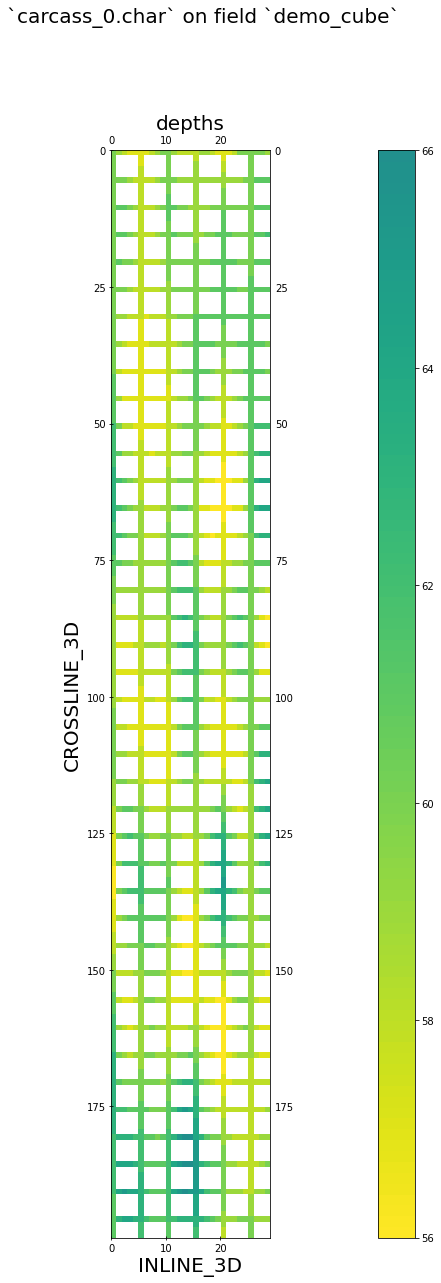

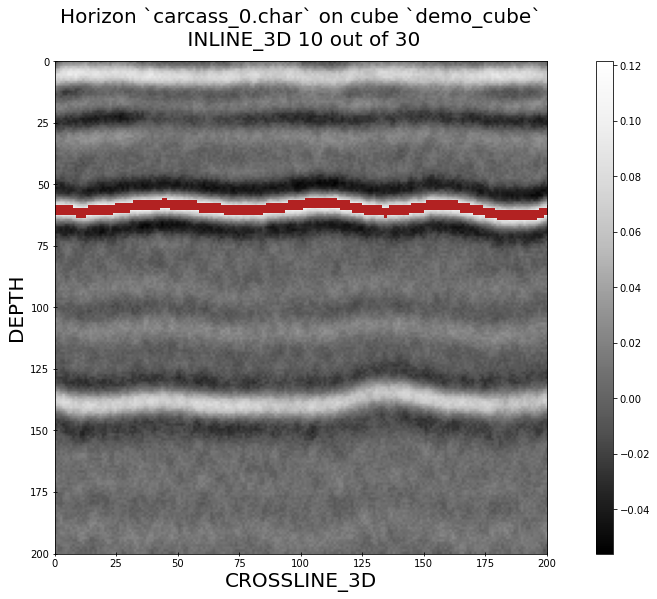

In [4]:
carcass.show(figsize=(66, 20))
carcass.show_slide(10, axis=0, figsize=(10, 10))

As we can see, there are very few slices. Note that some of them are `inline`-oriented, some of them are `xline`-oriented: our framework allows to dynamically sample slices in different directions.

As usual, we train the model on 3D crops of data cut from the cube. We need a mechanism of sampling such crops, and that is exactly what `Sampler` is doing. Output of the next cell shows actual sampled slices, that (potentially) can be used at training time. Color corresponds to frequency of the spatial point appearing in the batch.

CPU times: user 1.95 s, sys: 30.1 ms, total: 1.98 s
Wall time: 1.98 s


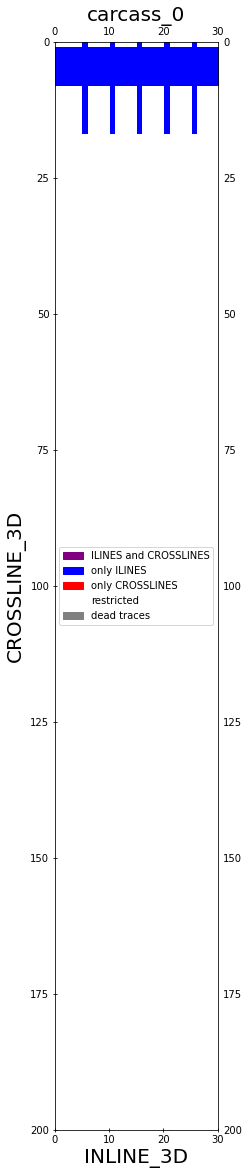

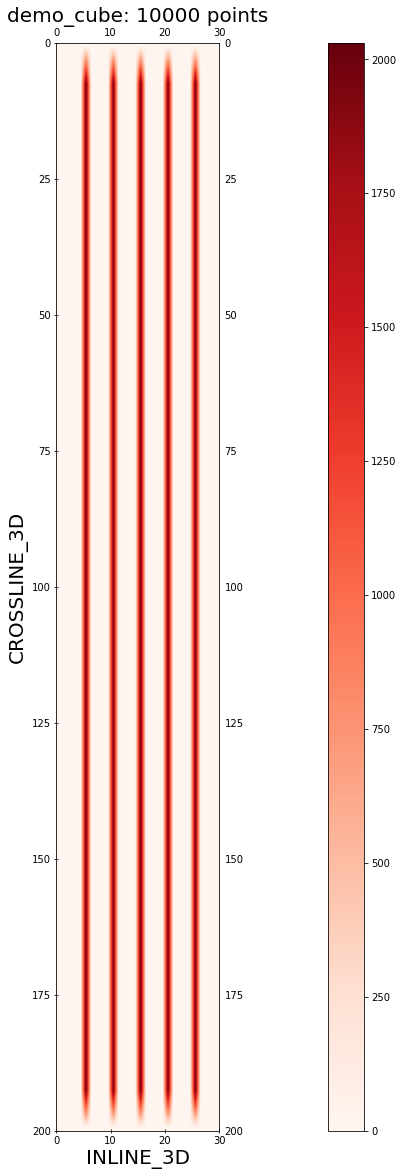

In [5]:
%%time
train_sampler = SeismicSampler(labels=train_dataset.labels, crop_shape=CROP_SHAPE,
                               threshold=0.7, mode='horizon')

train_sampler.show_locations(figsize=(122, 20))
train_sampler.show_sampled(figsize=(122, 20))

<a id='architecture'></a>
# Model architecture

We use convolutional neural network in `hourglass` manner, that consists of following parts:

- Initial processing via [`ResNet`](https://arxiv.org/abs/1512.03385) blocks
- Backbone to encode the image: it downsamples the input by a factor of 8
- Embedding layer
- Decoder, that takes output of the embedding and upsamples it to initial size, using pre-stored skip-connections to include informations from an earlier layers

We optimize Dice-coefficient with `Adam` algorithm. Due to enormous size of crops, we split every batch into pieces (called microbatches), accumulate gradients from each of them and, after the final piece is passed through, update neural network weights.

In [6]:
MODEL_CONFIG = {
    # Model layout
    'initial_block': {
        'base_block': ResBlock,
        'filters': 4,
        'kernel_size': 3,
        'downsample': False,
    },

    'body/encoder': {
        'num_stages': 3,
        'blocks': {
            'n_reps': 1,
            'filters': [4, 8, 16],
        },
    },
    'body/embedding': {
        'n_reps': 1,
        'filters': 16
    },
    'body/decoder': {
        'num_stages': 3,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks/filters': [8, 4, 2]
    },
    'head': {
        'filters': [2, 2],
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': 'bdice',
    'optimizer': {'name': 'Adam', 'lr': 0.05},
    'microbatch': 4,
    'common/activation': 'relu',
}

<a id='training'></a>
# Training

Pipeline of training consists of following steps:

- First of all, we create locations of crops to cut (`make_locations` action)
- Then we create masks and load actual seismic data
- As some of the crops are `iline`-oriented, and some of them are `xline`-oriented, we need to force equal shape on all of them. That is what `adaptive_reshape` for!
- We normalize seismic data by standard scaling: this way, most of the data is in $[-3, 3]$ range

In [7]:
train_template = (
    Pipeline()
    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .init_model(name='model', model_class=EncoderDecoder, config=MODEL_CONFIG)

    # Load data/masks
    .make_locations(generator=train_sampler, batch_size=BATCH_SIZE)
    .create_masks(dst='masks', width=4)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'])
    .normalize(src='images')

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
)

train_pipeline = train_template << train_dataset

In [8]:
%%time
batch = train_pipeline.next_batch()

CPU times: user 3.38 s, sys: 1.7 s, total: 5.08 s
Wall time: 6.3 s


In [9]:
train_pipeline.m('model').model

Sequential(
  (initial_block): ConvBlock(
    (0): ResBlock(
      (0): Sequential(
        (0): BaseConvBlock(
          layout=Rcnacn+a
          
          (Layer 0,    skip "R": (None, 1, 192, 192) -> (None, 4, 192, 192)): Branch(
            (layer): ConvBlock(
              (0): BaseConvBlock(
                layout=cn
                
                (Layer 0,  letter "c": (None, 1, 192, 192) -> (None, 4, 192, 192)): Conv(
                  (layer): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
                (Layer 1,  letter "n": (None, 4, 192, 192) -> (None, 4, 192, 192)): BatchNorm(
                  (layer): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )
              )
            )
          )
          (Layer 1,  letter "c": (None, 1, 192, 192) -> (None, 4, 192, 192)): Conv(
            (layer): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
          )
          (Layer 2,  le

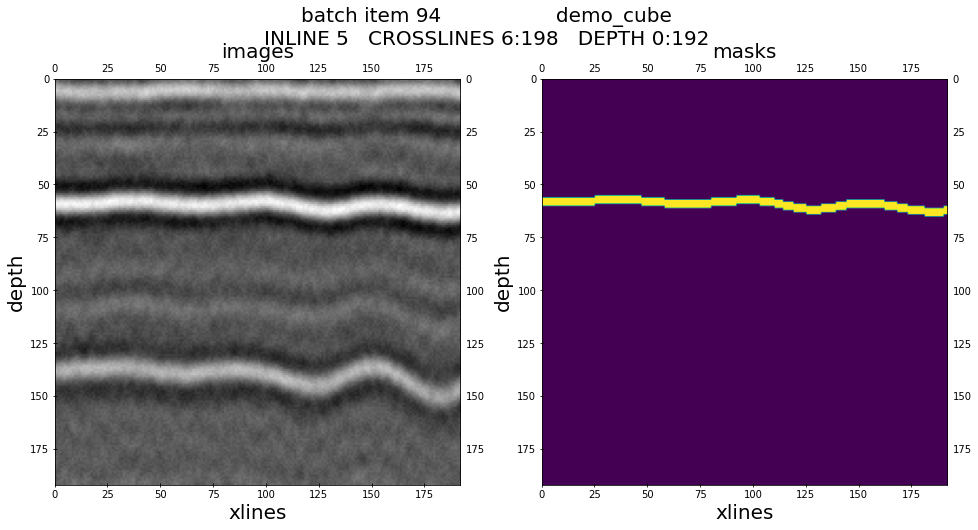

In [10]:
batch.show()

100%|██████████████████████████████| 50/50 [00:30<00:00,  1.63it/s, loss_history=0.063167]
CPU times: user 28.6 s, sys: 1.32 s, total: 29.9 s
Wall time: 30.7 s


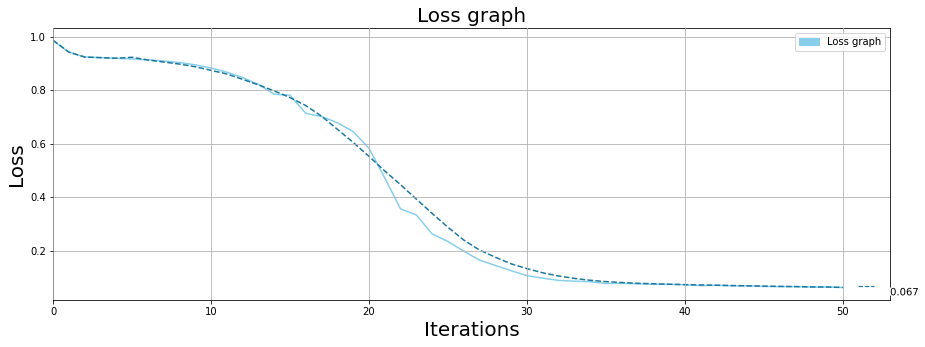

In [11]:
%%time
train_pipeline.run(n_iters=ITERS, bar={'bar': 't', 'monitors': 'loss_history'})

plot_loss(train_pipeline.v('loss_history'), final_mean=10)

We can see that loss platoed rather quickly. High fluctuations suggest that using larger batch size may be of help, as well as the more agressive learning rate scheduler.

<a id='validation'></a>
# Validation on patches

Now we can use the model on previously unseen data. Note that you will have target data only for synthetic data and all cells in that section can't be executed for real data in your task.

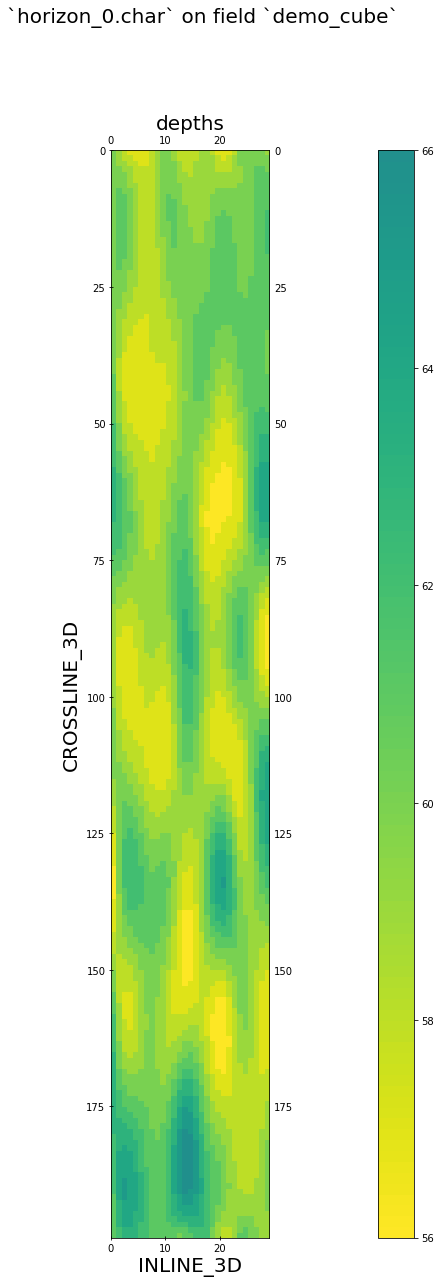

[None]

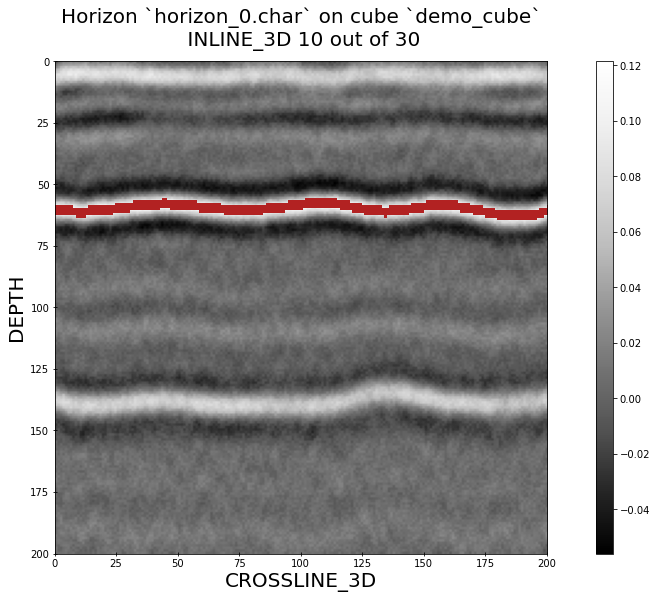

In [12]:
horizon_path = 'horizon_0.char'

test_dataset = SeismicDataset({cube_path : horizon_path}, labels_class='horizon')
horizon = test_dataset.labels[0]

horizon.show(figsize=(66, 20))
horizon.show_slide(10, axis=0, figsize=(10, 10))

Let's create test sampler, that is not tied to the grid in any way, and use it to thoroughly examine model performance:

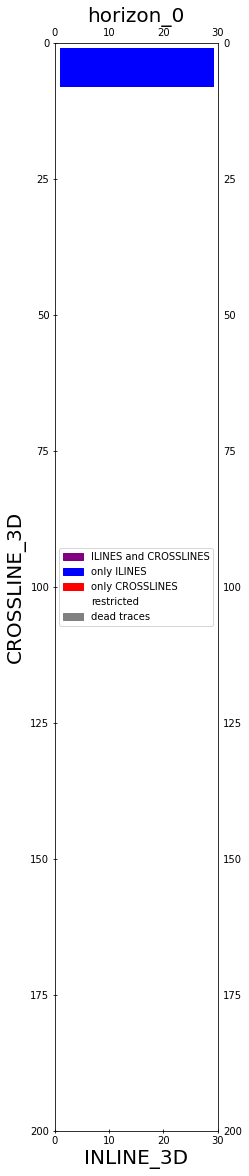

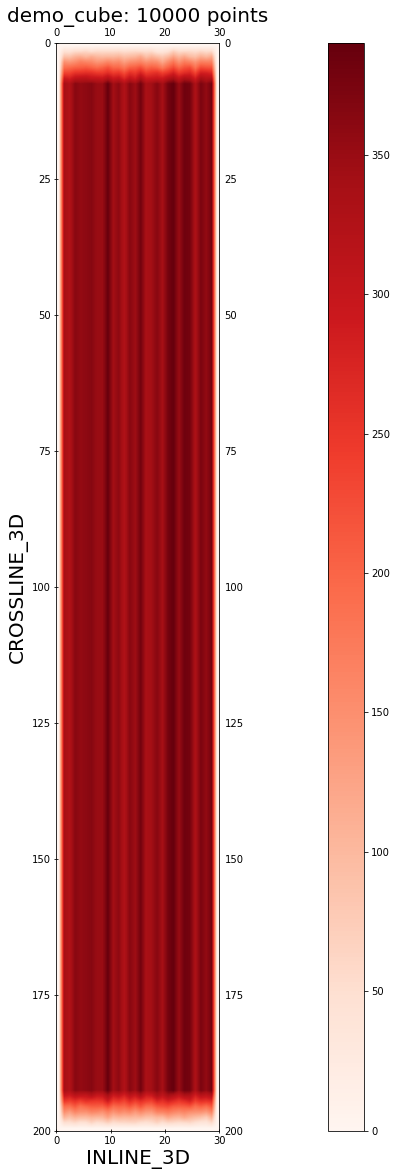

In [13]:
test_sampler = SeismicSampler(labels=test_dataset.labels, crop_shape=CROP_SHAPE,
                               threshold=0.7, mode='horizon')

test_sampler.show_locations(figsize=(122, 20))
test_sampler.show_sampled(figsize=(122, 20))

In [14]:
# Validation pipeline: no augmentations

val_template = (
    Pipeline()
    # Import model
    .import_model(name='model', source=train_pipeline)

    # Load data/masks
    .make_locations(generator=test_sampler, batch_size=4)
    .load_cubes(dst='images')
    .create_masks(dst='masks')
    .adaptive_reshape(src=['images', 'masks'])
    .normalize(src='images')

    # Predict with model
    .predict_model('model',
                   B('images'),
                   fetches='sigmoid',
                   save_to=B('predictions'))
    .transpose(src=['images', 'masks', 'predictions'],
               order=(1, 2, 0))
)
val_pipeline = val_template << test_dataset

In [15]:
batch = val_pipeline.next_batch()

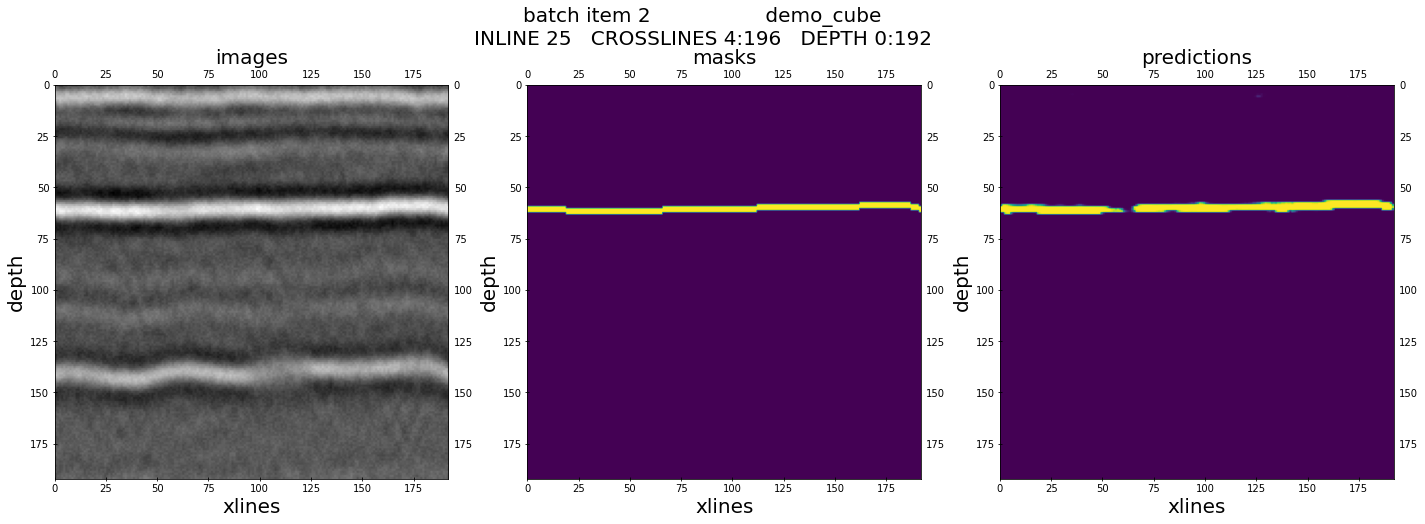

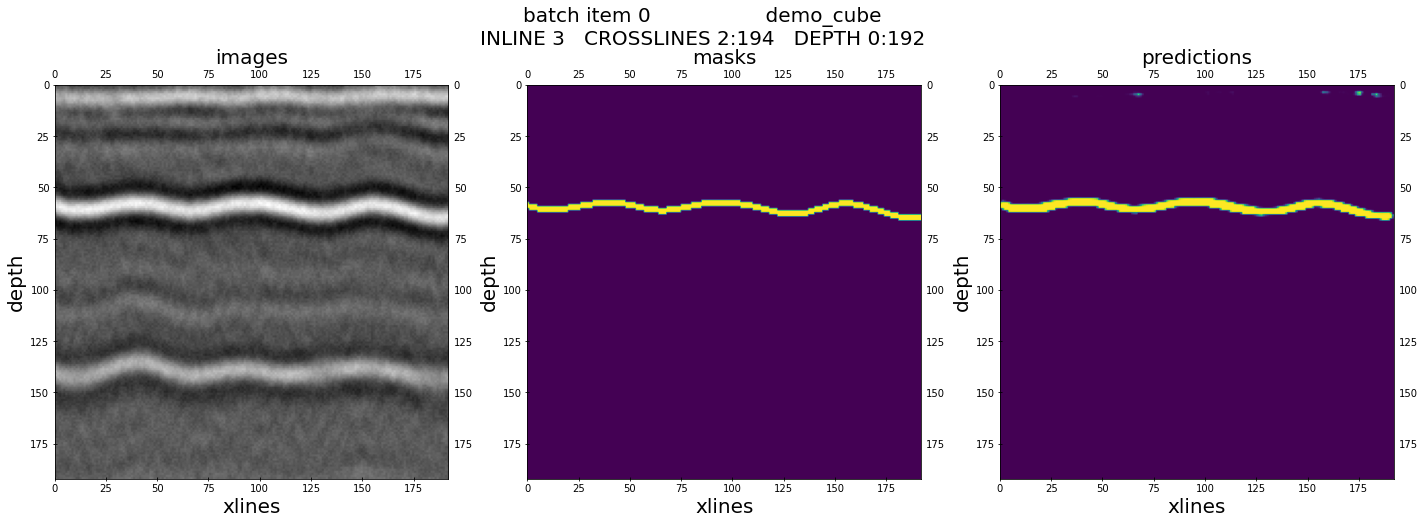

In [16]:
batch.show(2)

# Inference

Now is the perfect time to use our model to reconstruct the whole horizon: we can do so by:
- splitting the cube into chunks that cover the entire seismic range
- for each of them, make a prediction with the model
- aggregate predictions into one giant 3D array
- extract the horizon surface from it

Next cells do exactly that: `make_grid` creates grid of crop-sized chunks, `inference_pipeline` is used to make predictions, and `from_mask` method of `Horizon` allows us to locate the surface inside 3D array.

***Note that `from_mask` is more that capable of detecting and extracting multiple horizons from the volume. In the task of horizon interpolation we expect only one surface, so we take only the biggest of the produced horizons for later evaluation.***

In [17]:
inference_template = (
    Pipeline()
    # Initialize everything
    .import_model('model', train_pipeline)

    # Load data
    .make_locations(generator=C('grid'))
    .load_cubes(dst='images')
    .adaptive_reshape(src='images')
    .normalize(src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='sigmoid',
                   save_to=B('predictions'))
    .update_accumulator(src='predictions', accumulator=C('accumulator'))
)

We use a `RegularGrid` to create define locations of crops that would cover the desired range. `Accumulator3D` is continuously updated with new predictions, allowing us to reduce memory footprint: instead of keeping all of them in memory and aggregating later, we use and discard them right away.

In [18]:
%%time
grid = RegularGrid(field=field,
                   threshold=0,
                   ranges=[None, None, None],
                   batch_size=BATCH_SIZE*2,
                   crop_shape=CROP_SHAPE, overlap_factor=1)

accumulator = Accumulator3D.from_aggregation(aggregation='max',
                                             origin=grid.origin,
                                             shape=grid.shape,
                                             fill_value=0.0)

inference_pipeline = inference_template << train_dataset << {'grid': grid,
                                                             'accumulator': accumulator}

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.46 ms


In [19]:
%%time
inference_pipeline.run(n_iters=grid.n_iters, bar='t')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]
CPU times: user 260 ms, sys: 36 ms, total: 296 ms
Wall time: 526 ms


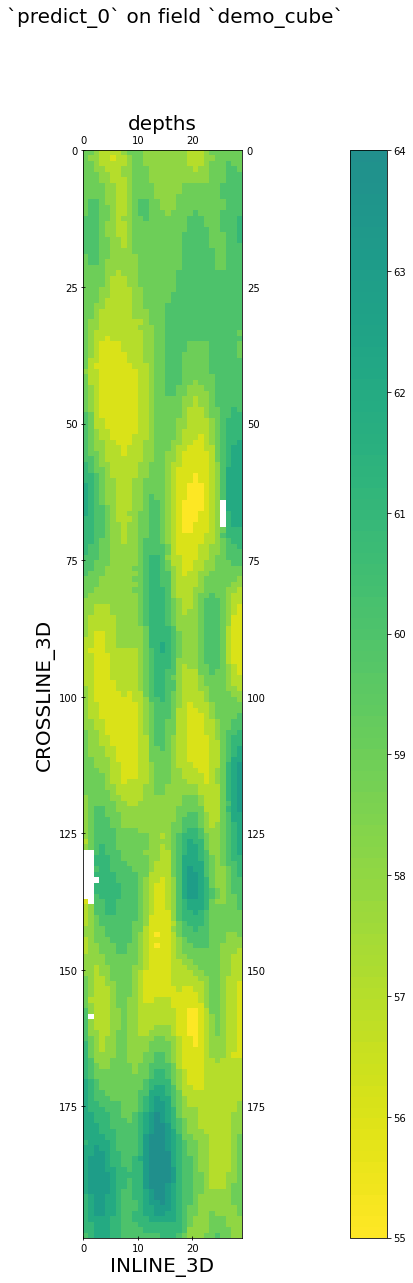

CPU times: user 727 ms, sys: 321 ms, total: 1.05 s
Wall time: 699 ms


In [20]:
%%time
aggregated = accumulator.aggregate()
horizons = Horizon.from_mask(aggregated, field=field, origin=grid.origin,
                             minsize=10000)

predicted_horizon = horizons[-1] # the biggest one
predicted_horizon.show(figsize=(66, 20))

Finally, we compare prediction and target horizon head-to-head:


Comparing horizons:
                                    predict_0
                               horizon_0.char
—————————————————————————————————————————————
Rate in 5ms:                            1.000
Mean/std of errors:               -0.88 / 0.46
Mean/std of abs errors:           0.89 / 0.46
Max error/abs error:                 1 /    2
—————————————————————————————————————————————
Lengths of horizons:                     5965
                                         6000
—————————————————————————————————————————————
Average heights of horizons:            58.69
                                        59.57
—————————————————————————————————————————————
Coverage of horizons:                  0.9942
                                       1.0000
—————————————————————————————————————————————
Solidity of horizons:                  0.9990
                                       1.0000
—————————————————————————————————————————————
Number of holes in horizons:                2
            

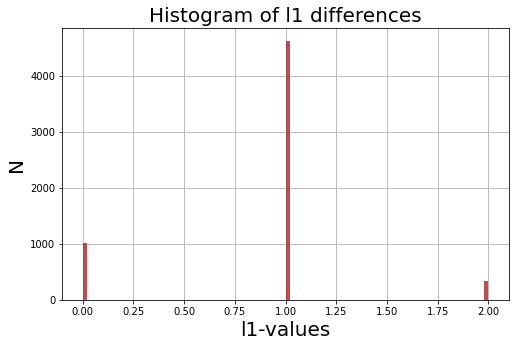

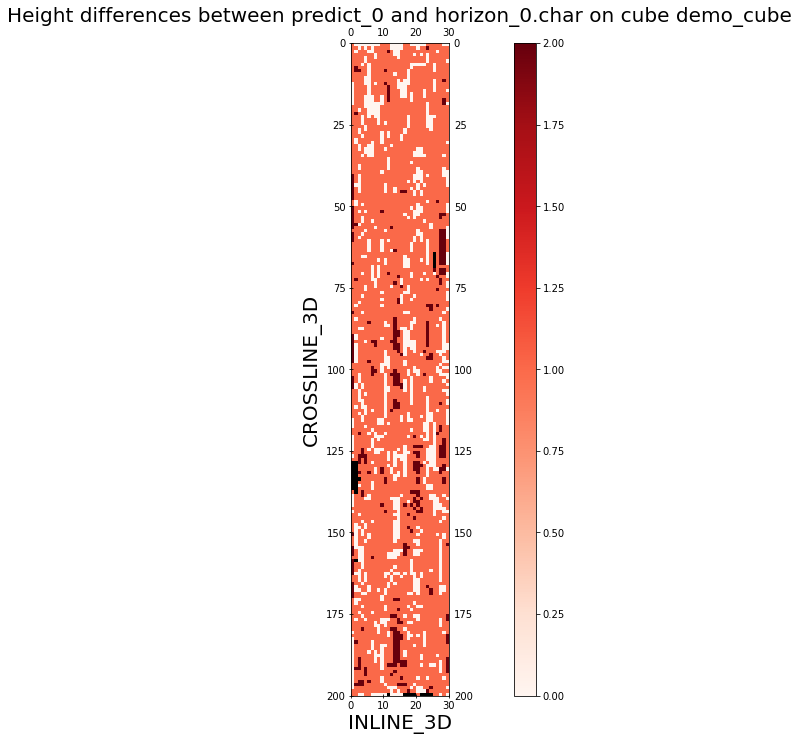

In [21]:
horizon = test_dataset.labels[0]

predicted_horizon.compare(horizon)

The `mean_error`, shown in the table above, is the metric used to evaluate submitted predictions.

Speaking about submissions, we can create one with a simple line:

In [22]:
predicted_horizon.dump('submission.char')

<a id='suggestions'></a>
# Suggestion for improvements

According to the recent papers, changing the inference `crop_shape` can lead to huge improvements on the quality of labeled surfaces: we must test this possibility.

Also, as we train model on tiny parts of batches, the `BatchNormalization` layer works suboptimally. Eliminating it (or its effects on train/test discrepancy) is a top priority.